In [7]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")
sys.path.append("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 5.6MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670901 sha256=ef48dfa89ef7574bea1957b6a912f7259a349c5875be63c1bf089a78d1a8c598
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
import surprise
from surprise import KNNBasic, SVD, NormalPredictor, KNNBaseline,KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, Reader, dataset, accuracy

In [5]:
pwd

'/content/drive/My Drive/Colab Notebooks'

In [8]:
recomm_df = pd.read_csv('ratings_Beauty.csv')

In [9]:
recomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [10]:
recomm_df.head()


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [11]:
recomm_df.shape

(2023070, 4)

In [12]:
recomm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,2023070.0,4.149036e+00,1.311505e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Timestamp,2023070.0,1.360389e+09,4.611860e+07,908755200.0,1.350259e+09,1.372810e+09,1.391472e+09,1.406074e+09


# ***Dropping the "timestamp" as it is not a needed field***

In [13]:
recomm_df = recomm_df.drop('Timestamp', axis=1)

# **Missing Value**

In [14]:
recomm_df.isna().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

In [15]:
recomm_df.shape

(2023070, 3)

## **plot histograms**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59ca306320>]],
      dtype=object)

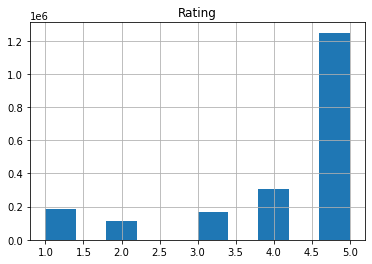

In [16]:
recomm_df.hist('Rating',bins = 10)

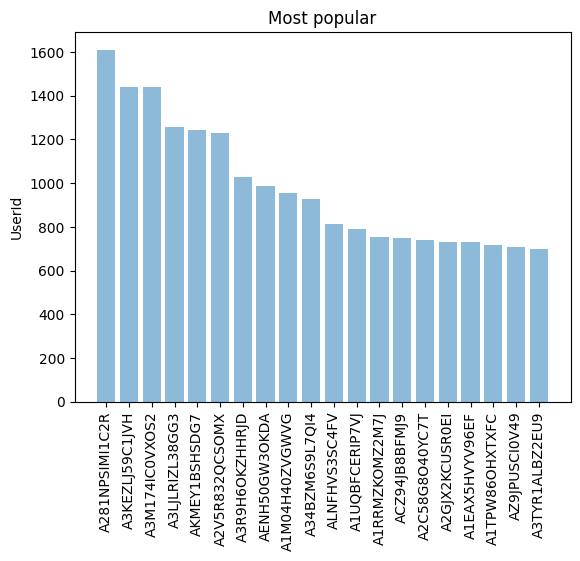

In [17]:
popular = recomm_df[['UserId','Rating']].groupby('UserId').sum().reset_index()
popular_20 = popular.sort_values('Rating', ascending=False).head(n=20)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (list(popular_20['UserId']))
y_pos = np.arange(len(objects))
performance = list(popular_20['Rating'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('UserId')
plt.title('Most popular')
 
plt.show()

In [19]:
# find unique users
recomm_df.UserId.value_counts()

A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
                 ... 
A28NNCATSZ0Y29      1
A2FB6DDOFNEMSK      1
A3IE3JR9Z59S8I      1
A24BB85D7J91VB      1
A3C6A40RHKRZBV      1
Name: UserId, Length: 1210271, dtype: int64

In [20]:
print('Number of unique users', len(recomm_df['UserId'].unique()))

Number of unique users 1210271


In [21]:
print('Number of unique products', len(recomm_df['ProductId'].unique()))

Number of unique products 249274


In [22]:
print('Unique Ratings', recomm_df['Rating'].unique())

Unique Ratings [5. 3. 4. 1. 2.]


In [23]:
min_ratings1 = recomm_df[(recomm_df['Rating'] < 2.0)]

In [24]:
print('Number of unique products rated low',len(min_ratings1['ProductId'].unique()))

Number of unique products rated low 66069


In [25]:
med_ratings1 = recomm_df[(recomm_df['Rating'] > 2.0) & (recomm_df['Rating'] < 4.0)]

In [26]:
print('Number of unique products rated medium',len(med_ratings1['ProductId'].unique()))

Number of unique products rated medium 65108


In [27]:
max_ratings1 = recomm_df[recomm_df['Rating'] >= 4.0]

In [28]:
print('Number of unique products rated high',len(max_ratings1['ProductId'].unique()))

Number of unique products rated high 220746


In [29]:
avg_rating_prod = recomm_df.groupby('ProductId').sum() / recomm_df.groupby('ProductId').count()

In [30]:
avg_rating_prod.drop('UserId', axis=1,inplace =True)


In [31]:
print ('Top 10 highly rated products \n',avg_rating_prod.nlargest(10,'Rating'))

Top 10 highly rated products 
             Rating
ProductId         
0205616461     5.0
0762451459     5.0
1304139212     5.0
1304139220     5.0
130414089X     5.0
1304146537     5.0
130414674X     5.0
1304168522     5.0
1304174778     5.0
1304174867     5.0


## ***keep the users only who has given 50 or more number of ratings***

In [32]:
userID = recomm_df.groupby('UserId').count()

In [33]:
top_user = userID[userID['Rating'] >= 50].index

In [34]:
topuser_ratings_df = recomm_df[recomm_df['UserId'].isin(top_user)]

In [35]:
topuser_ratings_df.shape

(29559, 3)

In [36]:
topuser_ratings_df.head()

,UserId,ProductId,Rating
5,AKJHHD5VEH7VG,0762451459,5.0
42,A22ZFXQE8AWPEP,1304482596,1.0
47,A22ZFXQE8AWPEP,1304482685,1.0
52,A22ZFXQE8AWPEP,1304495396,1.0
61,A22ZFXQE8AWPEP,1304511111,1.0


In [ ]:
topuser_ratings_df.sort_values(by='Rating', ascending=False).head()

,UserId,ProductId,Rating
184,ACZ94JB8BFMJ9,5357954771,5.0
563705,AJGU56YG8G1DQ,B001619XOG,5.0
559959,A1X1CEGHTHMBL1,B0015IW3PG,5.0
560016,AENH50GW3OKDA,B0015IYNR2,5.0
560237,A3QNV9LUNM589P,B0015KFWIO,5.0


## ***Keep data only for products that have 50 or more ratings***

In [37]:
prodID = recomm_df.groupby('ProductId').count()

In [38]:
top_prod = prodID[prodID['Rating'] >= 50].index

In [39]:
top_ratings_df = topuser_ratings_df[topuser_ratings_df['ProductId'].isin(top_prod)]

In [40]:
top_ratings_df.sort_values(by='Rating', ascending=False).head()

,UserId,ProductId,Rating
1717,A2FQZKL2KIZACO,9790790961,5.0
1436380,A2S7YBFPZX1IGQ,B005OZW3ZG,5.0
1435690,A1APERZNMEU8PW,B005OZGDO8,5.0
1435806,A1YVJ2CLK0L2WR,B005OZH88I,5.0
1435808,ADMPGWBF0BC9W,B005OZH88I,5.0


In [41]:
top_ratings_df.shape

(13717, 3)

# ***Split the data randomly into train and test dataset.***

In [42]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(top_ratings_df, test_size = 0.30, random_state=0)

In [43]:
train_data.head()

,UserId,ProductId,Rating
1812795,A1UQBFCERIP7VJ,B00AWLB9G6,5.0
1786137,A1UMSB7LAW0RIR,B00AE07CT8,2.0
84157,A2CHH5P055A0KL,B00027D8IC,4.0
486007,A10G136JEISLVR,B000YJ2SKM,5.0
1098154,A27FP0S5QH7GNE,B003TMO3EU,3.0


In [44]:
test_data.head()


,UserId,ProductId,Rating
1635236,ACZ94JB8BFMJ9,B0084A5PSK,5.0
1804057,ARYSDAZNRXN6G,B00AQ8NIC8,2.0
1786908,A3J029KBNG5MNP,B00AE07FXQ,4.0
932797,A2V5R832QCSOMX,B002UUT38I,5.0
97672,AKMEY1BSHSDG7,B0002RPTX4,5.0


# ***Build Popularity Recommender model.***

In [45]:
#Building the recommendations based on the average of all user ratings for each product.
train_data_grouped = train_data.groupby('ProductId').mean().reset_index()

In [46]:
train_data_grouped.head()

,ProductId,Rating
0,9790790961,5.000000
1,B00004TMFE,2.000000
2,B00004U9UY,4.333333
3,B000050B6U,2.500000
4,B000050B75,5.000000


In [47]:
train_data_sort = train_data_grouped.sort_values(['Rating', 'ProductId'], ascending=False)

In [48]:
train_data_sort.head()

,ProductId,Rating
3203,B00KHH2VOY,5.0
3202,B00KHGIK54,5.0
3201,B00KH6F6TM,5.0
3200,B00KGDRCZW,5.0
3199,B00KD73PBQ,5.0


In [ ]:
train_data.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head(10)

ProductId
B000142FVW    6
B001A5S3BM    5
B00008J2XQ    5
B001ET76EY    5
B000ODNSR0    5
B000AO2NXS    5
B000YZJMHS    5
B001JQLNPA    4
B00106AC06    4
B001T8MN16    4
Name: Rating, dtype: int64

In [49]:
ratings_mean_count = pd.DataFrame(train_data.groupby('ProductId')['Rating'].mean()) 

In [50]:
ratings_mean_count['rating_counts'] = pd.DataFrame(train_data.groupby('ProductId')['Rating'].count()) 

In [51]:
ratings_mean_count.head()  

,Rating,rating_counts
ProductId,,
9790790961,5.000000,2
B00004TMFE,2.000000,1
B00004U9UY,4.333333,3
B000050B6U,2.500000,2
B000050B75,5.000000,1


In [52]:
pred_df = test_data[['UserId', 'ProductId', 'Rating']]

In [53]:
pred_df.rename(columns = {'Rating' : 'true_ratings'}, inplace=True)

In [54]:
pred_df = pred_df.merge(train_data_sort, left_on='ProductId', right_on = 'ProductId')

In [55]:
pred_df.rename(columns = {'Rating' : 'predicted_ratings'}, inplace = True)

In [56]:
pred_df.head()

,UserId,ProductId,true_ratings,predicted_ratings
0,ACZ94JB8BFMJ9,B0084A5PSK,5.0,3.75
1,A2LAS014NSRW72,B0084A5PSK,5.0,3.75
2,A2OCDK0BOW6UCY,B0084A5PSK,5.0,3.75
3,ARYSDAZNRXN6G,B00AQ8NIC8,2.0,3.00
4,A1047EDJ84IMAS,B00AQ8NIC8,4.0,3.00


In [ ]:
import sklearn.metrics as metric
from math import sqrt
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.470797521558226


# ***Build Collaborative Filtering model***

In [ ]:
import surprise
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))

# ***Converting Pandas Dataframe to Surpise format***

In [ ]:
data = Dataset.load_from_df(top_ratings_df[['UserId', 'ProductId', 'Rating']],reader)

In [ ]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.3,random_state=0)

In [ ]:
type(trainset)

surprise.trainset.Trainset

# ***Training the model***

**KNNWithMeans**

In [ ]:
algo_user = KNNWithMeans(k=10, min_k=6, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_user.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


**SVD**

In [ ]:
svd_model = SVD(n_factors=50,reg_all=0.02)
svd_model.fit(trainset)

# ***Evaluate both the models.You can also use a different method to evaluate the models.***

In [ ]:
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.470797521558226


**Collaborative Filtering Recommender Model (RMSE)**

In [ ]:
print(len(testset))
type(testset)

522


list

**KNNWithMeans**

In [ ]:
# Evalute on test set
test_pred = algo_user.test(testset)
test_pred[0]

Prediction(uid='A2V5R832QCSOMX', iid='B000FS05VG', r_ui=3.0, est=4.065020576131687, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# compute RMSE
accuracy.rmse(test_pred) #range of value of error

RMSE: 1.3533


1.3533429041882414

**SVD**

In [ ]:
test_pred = svd_model.test(testset)

In [ ]:
# compute RMSE
accuracy.rmse(test_pred)

**Parameter tuning of SVD Recommendation system**

In [ ]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15], "reg_all":[0.01,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [ ]:
gs.fit(data)

In [ ]:
# get best parameters
gs.best_params

{'rmse': {'n_factors': 10, 'reg_all': 0.02}}

In [ ]:
# Use the "best model" for prediction
gs.test(testset)
accuracy.rmse(gs.test(testset))

RMSE: 1.0381


1.038146171782722

# ***Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products***

In [ ]:
from collections import defaultdict
def get_top_n(predictions, n=5):
  
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(test_pred, n=5)

In [ ]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2V5R832QCSOMX ['B000OW9QCW', 'B001V9LUO4', 'B000F63TW0', 'B003FV82VA', 'B001ET788S']
A12PH6L5QSVTYN ['B000C1VWCM', 'B002CMLHF6', 'B0009OAIIG', 'B000C230QC']
A1T61QP7QHYBRQ ['B001LF4G7G', 'B002VECKKG', 'B000H3I3Y0', 'B000YZGOZQ', 'B001GIOW3G']
ARYSDAZNRXN6G ['B001KFDHZE', 'B002QI1F8A', 'B0002A65LQ', 'B00021DJ32', 'B00021C1LI']
A3GU3CXHONZJQ6 ['B000BTO6EG', 'B000VOJPI8', 'B000C1W44M', 'B000C1Z7PA', 'B0009OAI1S']
A1RRMZKOMZ2M7J ['B000C1VT9S', 'B000C1Z19M', 'B002TSA916', 'B000JBWZR6', 'B000XE4CHK']
ACZ94JB8BFMJ9 ['B00016XJ4M', 'B001TJXI5U', 'B001N3FBZW', 'B0026IFLG2', 'B002JL1Y6C']
A132ETQPMHQ585 ['B000V70MWS', 'B000P6I3WG', 'B000ACB09I', 'B000WQU5IE', 'B000KONYPY']
A1WX42M589VAMQ ['B0011XZZF0', 'B001KMR9WY', 'B000QE6U54', 'B000VWL9KC', 'B001A3ML3K']
A3QNV9LUNM589P ['B001MA5VUQ', 'B001EJOPXE', 'B000P8DLF8', 'B002GOXELA', 'B000PHUKEE']
A1MI1I73Z5J9MI ['B000Q7XDR4', 'B000O3BDHW', 'B001H9275Y', 'B0010XUU9M', 'B002LFLPEC']
ALQGOMOY1F5X9 ['B000Q2RP7I', 'B001V9LUO4', 'B001NXBXYK', 'B000QA7HNC',